In [ ]:
import numpy as np
import pandas as pd
import io
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from google.colab import files
import statsmodels.api as sm
from scipy import stats
from itertools import product
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
 
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
uploaded = files.upload()

Saving avocado.csv to avocado (2).csv


## Описание датасета

Эти данные были загружены с веб-сайта Hass Avocado Board в мае 2018 года и представлены в формате .csv на сайте Kaggle. В таблице представлены данные еженедельного объема розничной торговли в стране и цен на авокадо. 

Средняя цена отражает стоимость за единицу авокадо, даже когда несколько единиц продаются в сумках. Данные собраны только для авокадо компании Hass, в соответствии с кодами поиска продуктов (PLU). Другие разновидности авокадо (например, зеленокожие) не включены в эту таблицу.

Описание некоторых столбцов:
- Date - дата наблюдения
- AveragePrice - средняя цена одного авокадо в US dollars
- TotalVolume - общее количество проданных авокадо
- 4046 - общее количество проданных авокадо с PLU 4046
- 4225 - общее количество проданных авокадо с PLU 4225
- 4770 - общее количество проданных авокадо с PLU 4770
- type - обычный или органический тип 
- year - год налюдения
- region - город или район наблюдения

In [ ]:
data = pd.read_csv(io.StringIO(uploaded['avocado.csv'].decode('utf-8')), index_col='Unnamed: 0', parse_dates=['Date'])
# data = pd.read_csv('/avocado.csv', sep=',', index_col='Unnamed: 0', parse_dates=['Date'])
data.head()

Date  AveragePrice  Total Volume  ...          type  year  region
0 2015-12-27          1.33      64236.62  ...  conventional  2015  Albany
1 2015-12-20          1.35      54876.98  ...  conventional  2015  Albany
2 2015-12-13          0.93     118220.22  ...  conventional  2015  Albany
3 2015-12-06          1.08      78992.15  ...  conventional  2015  Albany
4 2015-11-29          1.28      51039.60  ...  conventional  2015  Albany

[5 rows x 13 columns]

Значения и единицы столбцов <em>Total Bags, Small Bags, Large Bags, XLarge Bags</em> неспецифицированы в описании, но видно, что <em>Total Volume = 4046 + 4225 + 4770 + Total Bags</em> и <em>Total Bags = Small Bags + Large Bags + XLarge Bags</em>. 

Будем в дальнейшем предполагать, что столбцы <em>Total Volume, 4046, 4225, 4770, Total Bags, Small Bags, Large Bags</em> и <em>XLarge Bags</em> оторажают количество проданных авокадо в кг. 

In [ ]:
# переименуем столбцы для удобства
data.columns = ['date', 'avg_price', 'total_vol', '4046', '4225', '4770', 'total_bags', 'small_bags', 'large_bags',
               'xlarge_bags', 'type', 'year', 'region']

## Формулировка задачи

**На основе имеющихся исторических данных построить модель машинного обучения, позволяющую предсказать среднюю цену на авокадо.**

Выделим подзадачи:
<ol>
<li>Провести описательный анализ, визуализировать данные и оценить корреляцию столбцов с целевой переменной - <em>avg_price</em></li>
<li>Предобработать данные</li>
<li>Построить базовый алгоритм линейной регрессии</li>
<li>Попробовать регуляризировать полученную модель</li>
<li>Построить случайных лес и оценить качество его работы</li>
<li>Построить модель градиентного бустинга с различными параметрами</li>
<li>Опробовать методы анализа временных рядов для предсказания средней цены</li>
<li>Сделать выводы</li>
</ol>

## Анализ данных

In [ ]:
data.describe()

avg_price     total_vol  ...    xlarge_bags          year
count  18249.000000  1.824900e+04  ...   18249.000000  18249.000000
mean       1.405978  8.506440e+05  ...    3106.426507   2016.147899
std        0.402677  3.453545e+06  ...   17692.894652      0.939938
min        0.440000  8.456000e+01  ...       0.000000   2015.000000
25%        1.100000  1.083858e+04  ...       0.000000   2015.000000
50%        1.370000  1.073768e+05  ...       0.000000   2016.000000
75%        1.660000  4.329623e+05  ...     132.500000   2017.000000
max        3.250000  6.250565e+07  ...  551693.650000   2018.000000

[8 rows x 10 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
date           18249 non-null datetime64[ns]
avg_price      18249 non-null float64
total_vol      18249 non-null float64
4046           18249 non-null float64
4225           18249 non-null float64
4770           18249 non-null float64
total_bags     18249 non-null float64
small_bags     18249 non-null float64
large_bags     18249 non-null float64
xlarge_bags    18249 non-null float64
type           18249 non-null object
year           18249 non-null int64
region         18249 non-null object
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.9+ MB


Явных пропущенных значений нет, почти все признаки количественные. Проверим периодичность данных и категориальные признаки.

In [ ]:
data['date'].value_counts().sort_index()

2015-01-04    108
2015-01-11    108
2015-01-18    108
2015-01-25    108
2015-02-01    108
             ... 
2018-02-25    108
2018-03-04    108
2018-03-11    108
2018-03-18    108
2018-03-25    108
Name: date, Length: 169, dtype: int64

In [ ]:
data['type'].value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

In [ ]:
data['region'].value_counts()

CincinnatiDayton       338
NorthernNewEngland     338
Portland               338
HartfordSpringfield    338
Nashville              338
Orlando                338
Columbus               338
BaltimoreWashington    338
Seattle                338
LasVegas               338
Houston                338
NewOrleansMobile       338
Syracuse               338
SanFrancisco           338
Boise                  338
SouthCentral           338
Atlanta                338
StLouis                338
Albany                 338
PhoenixTucson          338
Pittsburgh             338
Plains                 338
Midsouth               338
Chicago                338
Louisville             338
GreatLakes             338
Southeast              338
Northeast              338
HarrisburgScranton     338
NewYork                338
SanDiego               338
Philadelphia           338
Charlotte              338
West                   338
Boston                 338
RaleighGreensboro      338
Tampa                  338
D

In [ ]:
data[(data.region == 'TotalUS') | (data.date == '2015-01-04')].loc[:, 'total_vol'].sum()

5917477331.12

In [ ]:
data[(data.region != 'TotalUS') | (data.date == '2015-01-04')].loc[:, 'total_vol'].sum()

9690599599.48

Совершенно сомнительное кат.значение $TotalUS$, не совпадающее с количеством купленных авокадо во всех регионах США. В рамках имеющегося датасета остается неясным, является ли эта категория дублирующей с пропусками или просто отвечает за остальные регионы. Предположим, что то данные других регионов, и оставим.

In [ ]:
num_cols = data.select_dtypes(include = np.number).columns
num_cols

Index(['avg_price', 'total_vol', '4046', '4225', '4770', 'total_bags',
       'small_bags', 'large_bags', 'xlarge_bags', 'year'],
      dtype='object')

Построим гистограммы для оценки распределений количественных признаков. Посмотрим на выбросы. 

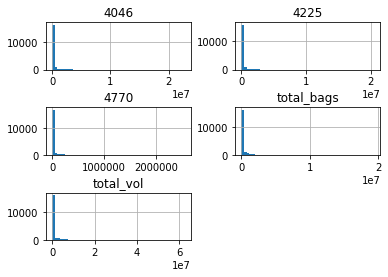

In [ ]:
data[['total_vol', '4046', '4225', '4770', 'total_bags']].hist(bins=50)
plt.subplots_adjust(hspace=0.8)

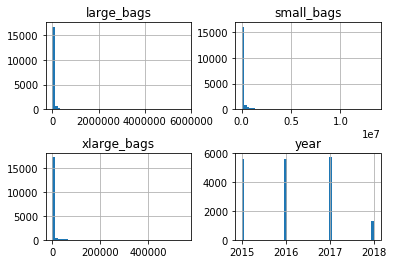

In [ ]:
data[['small_bags', 'large_bags', 'xlarge_bags', 'year']].hist(bins=50)
plt.subplots_adjust(hspace=0.5)

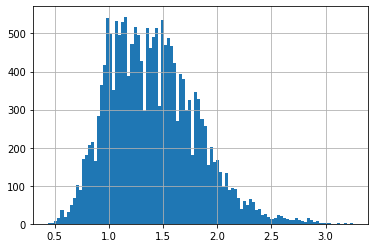

In [ ]:
data['avg_price'].hist(bins=100)

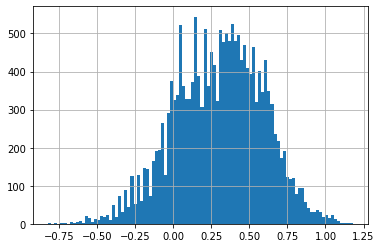

In [ ]:
np.log(data['avg_price']).hist(bins=100)

Видно, что признаки многие имеют очень неприятный разброс значений с пиком в нуле. Частично, это объясняется особенностью записей в датасете, где количество проданных авокадо хранится отдельно для каждого типа.

Посмотрим, коррелируют ли признаки между собой и какие имеют зависимости.

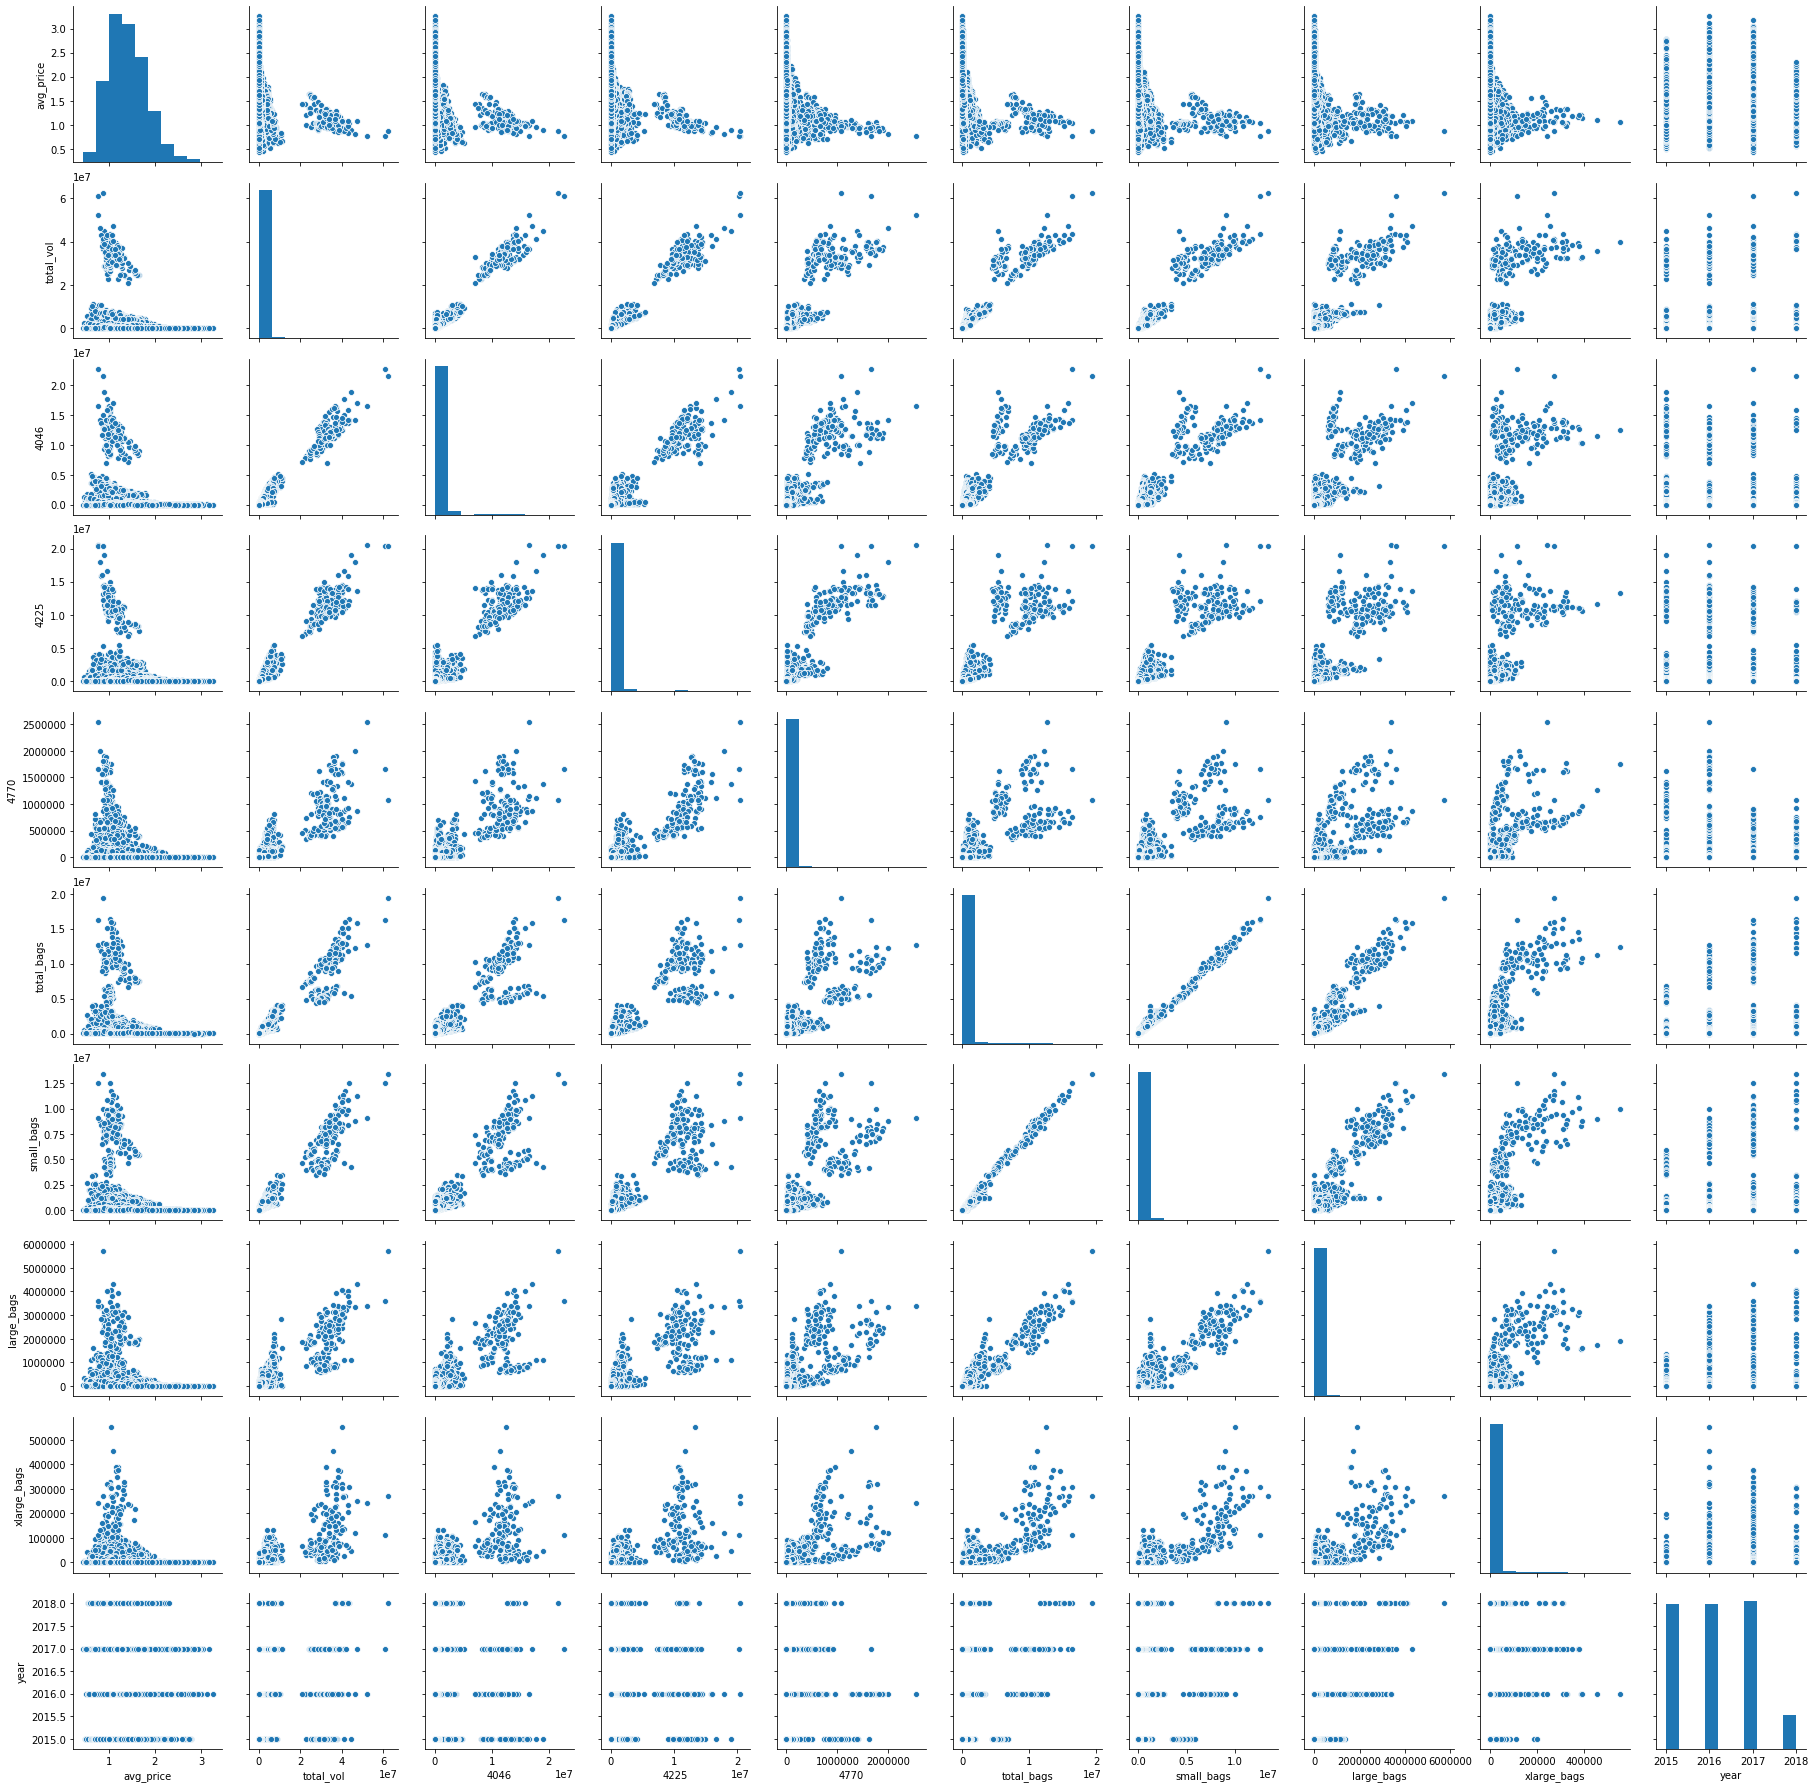

In [ ]:
sns.pairplot(data)

Очень любопытно, что многие pairplot-ы получились линейно разделимыми. При наличии категориального признака с двумя значениями. Это наводит на определенные мысли!
<br>
Большинство признаков имеет схожие зависимости от целевой переменной avg_price со "всплеском" около единицы. Череда взаимосвязей total_bags и объемов продаж small_bags, large_bags, xlarge_bags, объясняется преобладанием "маленьких" закупок. Здорово, что растут объемы bags (кроме xlarge - его колеблет) с течением лет.

Проанализируем категориальные признаки.

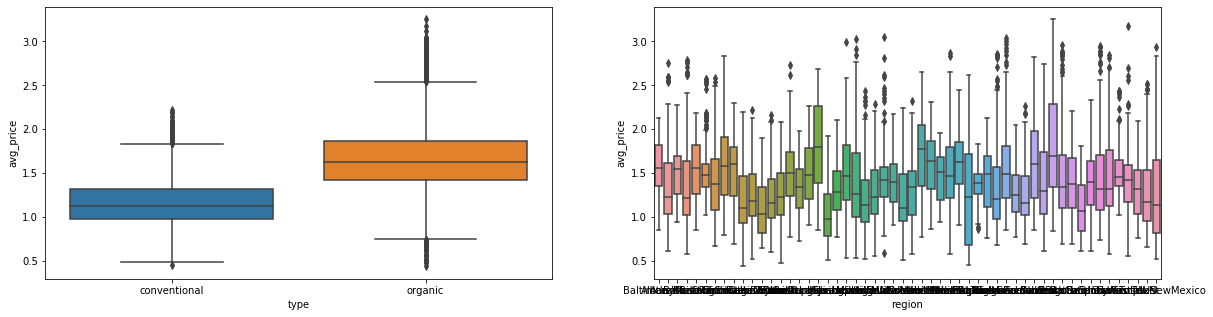

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.boxplot(x='type', y='avg_price', data=data, ax=ax[0]) 
sns.boxplot(x='region', y='avg_price', data=data, ax=ax[1]) 

Очень хорошо видна разница между типами авокадо и средней ценой. Ценник в разных регионах тоже выглядит разнообразно, нет причин отказываться от признака. Но и пока не хочется разделять прогнозирование для разных регионов по отдельности. 

Проверим догадку и сраним pairplot-ы авокадо разных типов:

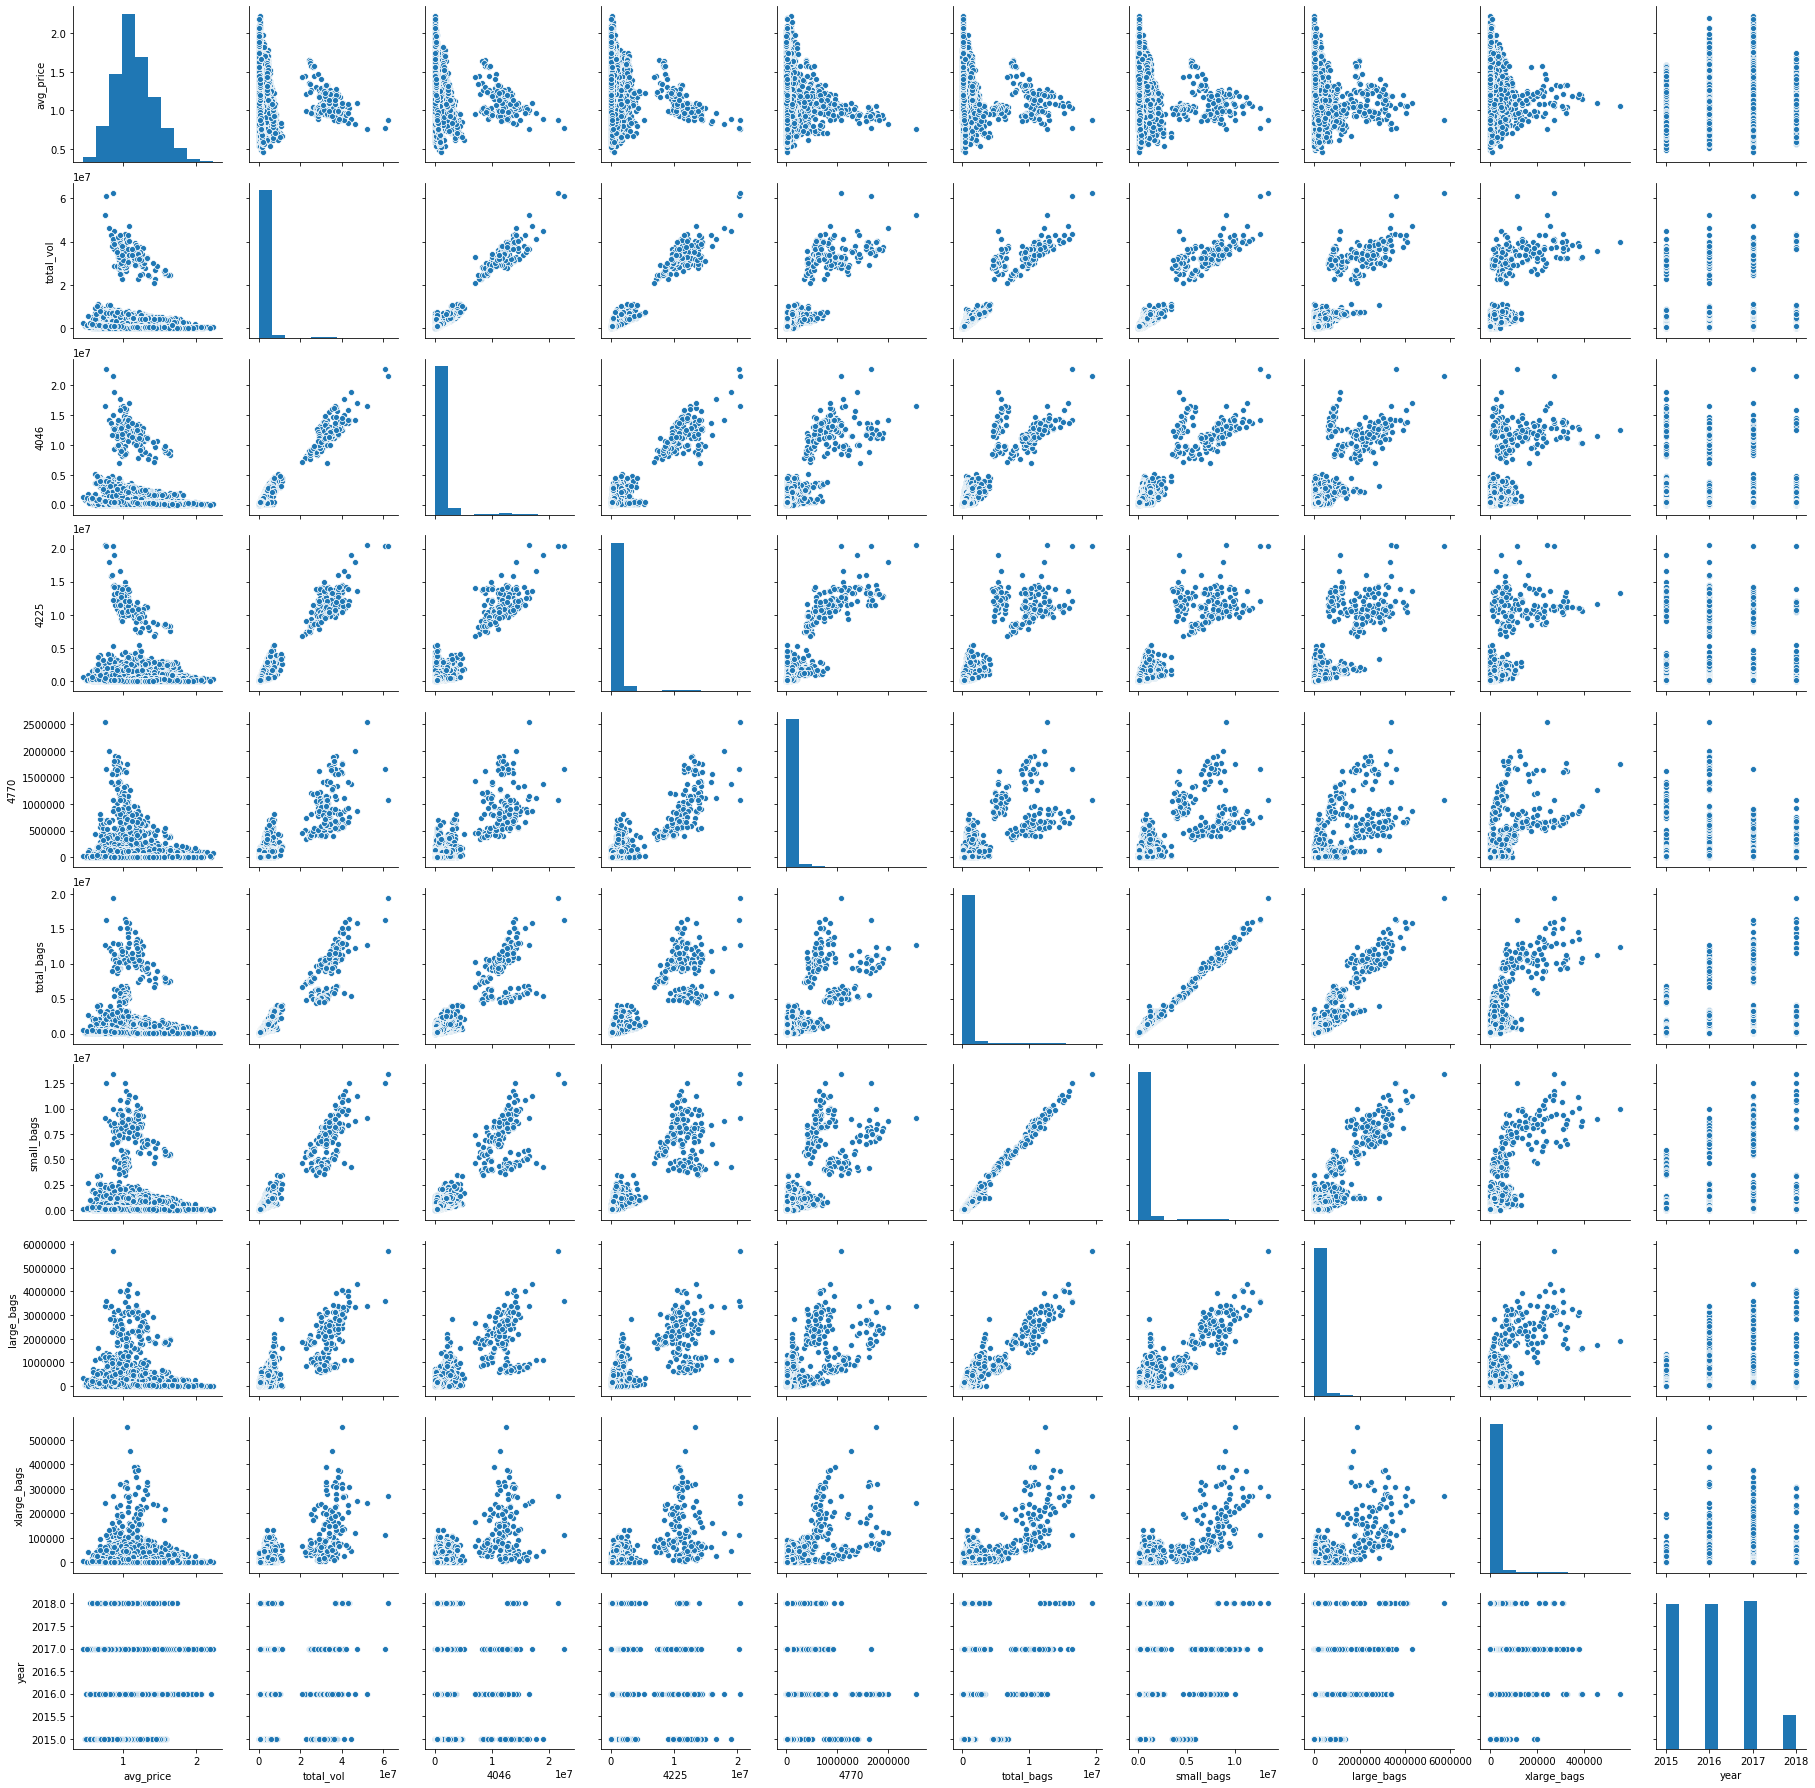

In [ ]:
conventional = data[data['type'] == 'conventional']

sns.pairplot(conventional)

Та-да-да-дам. Разделение авокадо по типу не устранило особенностей графиков, и вопросы остались. Тогда остается только предположить, что существует пробел в рациональных объемах покупки авокадо: продают либо совсем немного, либо оптом. Странно, что оптовая закупка почти никак не сказывается на цене.

Посмотрим внимательнее на объемы.

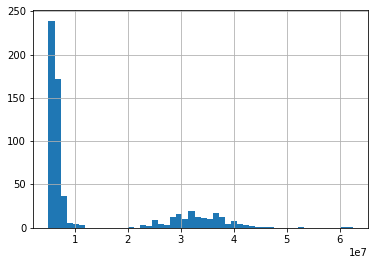

In [ ]:
data[data['total_vol'] > 10**7/2]['total_vol'].hist(bins=50)

Данные очевидно группируются в две категории по объему продажи. Можно предположить, что этот разрыв и влечет различие и относительно других признаков. Можно посмотреть, улучшится ли качество предсказания цены у моделей, если датасет разделить и обучать их на подвыборках с теми масштабами, которые хотим предсказывать: отдельно цену по мелким продажам, отдельно по крупным.

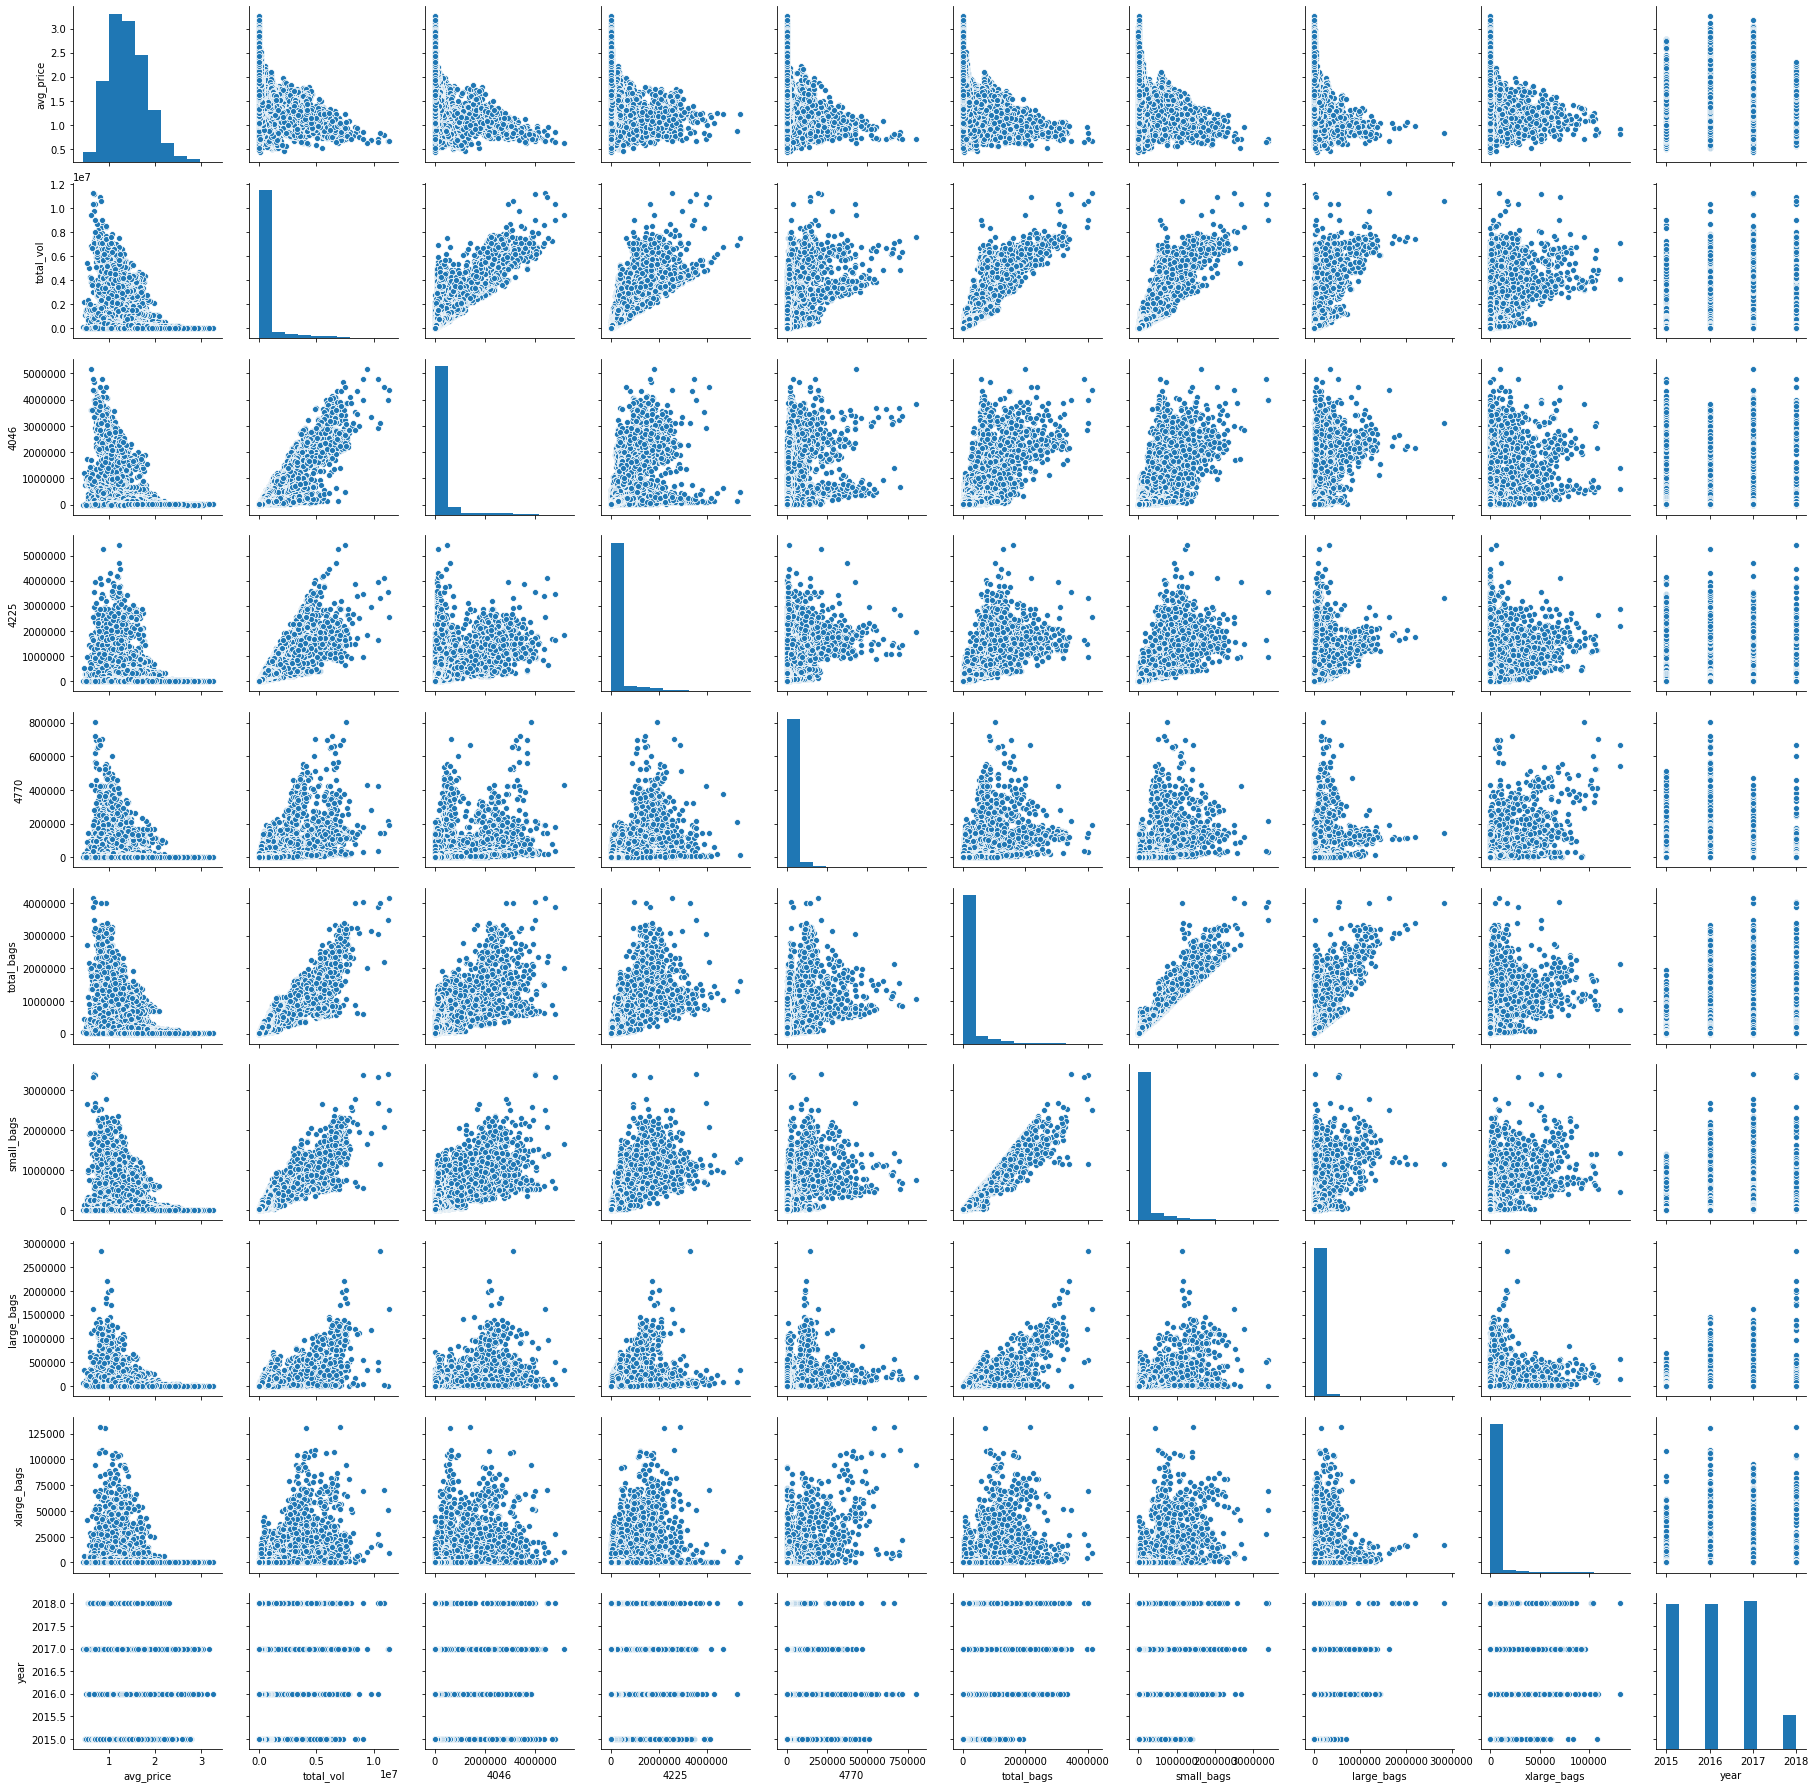

In [ ]:
df_small = data[data['total_vol'] < 1.5*10**7]
df_large = data[data['total_vol'] >= 1.5*10**7]

sns.pairplot(df_small)

Осталось посмотреть на корреляцию всех признаков.

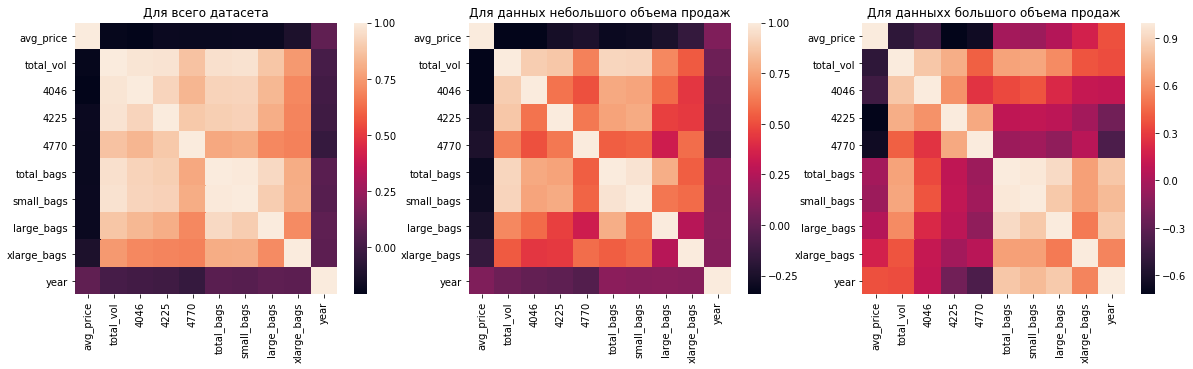

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

sns.heatmap(data.select_dtypes(include=['float64', 'int']).corr(), ax=ax[0])
ax[0].title.set_text("Для всего датасета")
sns.heatmap(df_small.select_dtypes(include=['float64', 'int']).corr(), ax=ax[1])
ax[1].title.set_text("Для данных небольшого объема продаж")
sns.heatmap(df_large.select_dtypes(include=['float64', 'int']).corr(), ax=ax[2])
ax[2].title.set_text("Для данныхх большого объема продаж")

Для датасета целиком видно отсутствие каких-либо связей с целевой переменной, все корреляции меньше 0.1. Яркий центр легко описывается смыслом признаков - они действительно сильно скоррелированны. При разделении данных ситуация меняется: при большом объеме продаж корреляция с признаками увеличивается.

Однако размер выборки с большими продажами слишком мал - всего 169 записей. Отбросим его как хвост распределения.

## Преобразование признаков

Логарифмируем целевую переменную, удалим дублирующие признаки $TotalVol, TotalBags$, временной $Date$ (анализ временных рядов будет осуществлен в другой части проекта). Разделим данные на обучающую и тестовую выборки. Применим $one-hot-encoding$ для кодирования категориальных переменных.

In [ ]:
df_small.loc[:,'avg_price'] = np.log(df_small['avg_price'])

In [ ]:
df_small.head()

date  avg_price  total_vol  ...          type  year  region
0 2015-12-27   0.285179   64236.62  ...  conventional  2015  Albany
1 2015-12-20   0.300105   54876.98  ...  conventional  2015  Albany
2 2015-12-13  -0.072571  118220.22  ...  conventional  2015  Albany
3 2015-12-06   0.076961   78992.15  ...  conventional  2015  Albany
4 2015-11-29   0.246860   51039.60  ...  conventional  2015  Albany

[5 rows x 13 columns]

In [ ]:
df_small = df_small.drop(columns=['total_vol', 'total_bags', 'date'])   

In [ ]:
X = df_small.drop(columns=['avg_price'])
y = df_small['avg_price']

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train.head()

4046      4225   4770  ...     type  year      region
26  15429.90  25963.83   0.00  ...  organic  2015  LosAngeles
9    1009.65     87.95   0.00  ...  organic  2016  Pittsburgh
6    5261.02    639.37  35.39  ...  organic  2018      Denver
24   4653.22  20980.13  28.11  ...  organic  2015      Plains
30   2184.08   3605.15   0.00  ...  organic  2017  Sacramento

[5 rows x 9 columns]

In [ ]:
def preproc(train, test):
    num_cols = ['4046', '4225', '4770', 'small_bags', 'large_bags', 'xlarge_bags']
    cat_cols = ['type', 'region', 'year']

    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(train[cat_cols])
    X_encoded = ohe.transform(train[cat_cols])

    features_names_prefixed = []
    for cats in ohe.categories_:
        for cat in cats:
            features_names_prefixed.append(str(cat))

    X_preproc = pd.concat([train[num_cols], pd.DataFrame(X_encoded, columns=features_names_prefixed, 
                           index=train.index)], axis=1)
    
    X_test_encoded = ohe.transform(test[cat_cols])
    X_test_preproc = pd.concat([test[num_cols], pd.DataFrame(X_test_encoded, columns=features_names_prefixed, 
                           index=test.index)], axis=1)
    return X_preproc, X_test_preproc

In [ ]:
X_preproc, X_test_preproc = preproc(X_train, X_test)
X_preproc.head()

4046      4225   4770  small_bags  ...  2015  2016  2017  2018
26  15429.90  25963.83   0.00     7027.42  ...   1.0   0.0   0.0   0.0
9    1009.65     87.95   0.00     7224.88  ...   0.0   1.0   0.0   0.0
6    5261.02    639.37  35.39    16367.04  ...   0.0   0.0   0.0   1.0
24   4653.22  20980.13  28.11     5262.78  ...   1.0   0.0   0.0   0.0
30   2184.08   3605.15   0.00     1029.60  ...   0.0   0.0   1.0   0.0

[5 rows x 66 columns]

## Линейные модели

Попробуем некоторые базовые подходы, такие как линейная регрессия и ridge-регрессия (с $L_2$ регуляризацией).

In [ ]:
def lin_reg(X_train, y_train, X_test, y_test):
  regFB = LinearRegression(normalize=True)

  regFB.fit(X_train, y_train)
  y_pred = regFB.predict(X_test)

  print("Параметры линейной регрессии:", regFB.intercept_, regFB.coef_)
  print("MSE линейной регрессии:", metrics.mean_squared_error(y_test, y_pred))

  plt.scatter(y_pred, y_test, color = 'red')
  plt.xlabel('Предсказанные значения')
  plt.ylabel("Реальные значения")

Малый объем:
Параметры линейной регрессии: -99610004681.4947 [-6.62196080e-08 -2.85368150e-08 -1.38265907e-07  6.39801113e-10
 -7.07462402e-08  2.93876238e-06  5.50774692e+10  5.50774692e+10
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e+11  1.18060919e+11  1.18060919e+11
  1.18060919e+11  1.18060919e

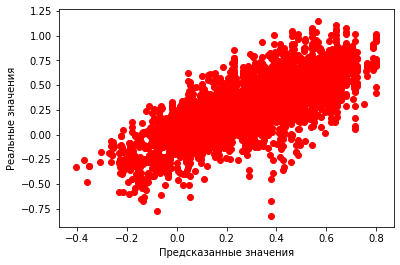

In [ ]:
print("Малый объем:")
lin_reg(X_preproc, y_train, X_test_preproc, y_test)

Весь объем:
Параметры линейной регрессии: -158025748032.68872 [-2.71031500e-08  1.50533697e-08 -1.10146619e-07  1.80687336e-08
 -7.59406975e-08  1.22082350e-06  2.15552038e+10  2.15552038e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230e+10  2.11747230e+10  2.11747230e+10
  2.11747230e+10  2.11747230

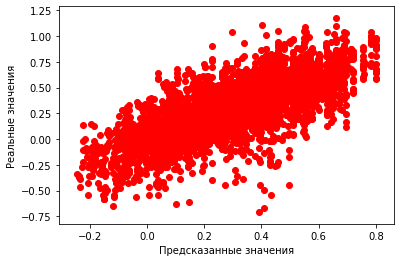

In [ ]:
data.loc[:,'avg_price'] = np.log(data['avg_price'])
data = data.drop(columns=['total_vol', 'total_bags', 'date'])   
X_full = data.drop(columns=['avg_price'])
y_full = data['avg_price']
X_train_full, X_test_full, y_train_full, y_test_full = model_selection.train_test_split(X_full, y_full, test_size=0.25, random_state=42)
X_preproc_full, X_test_preproc_full = preproc(X_train_full, X_test_full)

print("Весь объем:")
lin_reg(X_preproc_full, y_train_full, X_test_preproc_full, y_test_full)

Качество на всем датасете оказывается чуточку хуже, чем отдельно на малых объемах продаж. Регрессия, построенная для больших объемов продаж показала намного лучшее качество, но в силу малости выборки здесь не приводится.

Если взглянуть на коэффициенты регрессии, то видно, что при трансформированных категориальных признаках коэф-ты одинаковые и большие по модулю. В то же время при количественных признаках коэф-ты малы по модулю. При признаках 4225, small_bags, xlarge_bags коэф-ты положительны, при остальных же - отрицательны.

Будем штрафовать модель за сложность:

In [ ]:
regR = Ridge(random_state=42)

parameters_grid = {
    'alpha' : [0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0],
    'normalize' : [True, False]
}

sss = model_selection.StratifiedShuffleSplit(n_splits = 5, random_state = 42)
grid_cv = model_selection.GridSearchCV(regR, parameters_grid, scoring = 'neg_mean_squared_error')

In [ ]:
%%time
grid_cv.fit(X_preproc, y_train)

CPU times: user 1.02 s, sys: 1.33 s, total: 2.35 s
Wall time: 1.21 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=42,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-0.03386149782801518
{'alpha': 2.0, 'normalize': False}


MSE гребневой регрессии: 0.03295754478244826


Text(0, 0.5, 'Реальные значения')

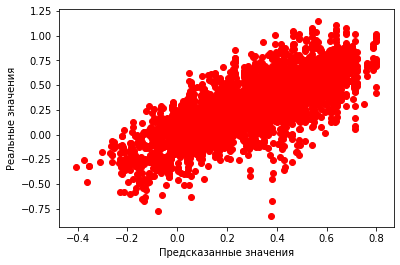

In [ ]:
best_model = grid_cv.best_estimator_
y_pred_ridge = best_model.predict(X_test_preproc)

print("MSE гребневой регрессии:", metrics.mean_squared_error(y_test, y_pred_ridge))

plt.scatter(y_pred_ridge, y_test, color = 'red')
plt.xlabel('Предсказанные значения')
plt.ylabel("Реальные значения")

Качество улучшилось совсем незначительно. 

## Случайный лес

Построим случайный лес и подберем параметры.

In [ ]:
rf = RandomForestRegressor(random_state=42)

parameters_grid = {
    'n_estimators' : [5, 8, 10, 25, 50],
    'max_depth' : range(2, 8),
    'min_samples_split' : range(2, 5),
    'min_samples_leaf' : range(1, 5),
    'bootstrap' : [True, False]
}

grid_cv = model_selection.GridSearchCV(rf, parameters_grid, scoring = 'neg_mean_squared_error')

In [ ]:
%%time
grid_cv.fit(X_preproc, y_train)

CPU times: user 17min 27s, sys: 856 ms, total: 17min 28s
Wall time: 17min 29s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False], 

Параметры лучшей модели:  {'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
MSE случайного леса: 0.02548077323964452


Text(0, 0.5, 'Реальные значения')

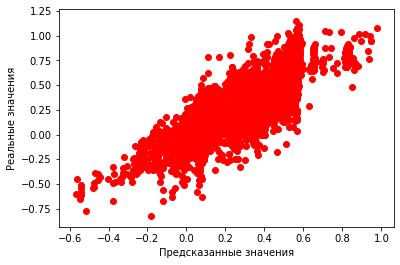

In [ ]:
print("Параметры лучшей модели: ", grid_cv.best_params_)

best_model = grid_cv.best_estimator_
y_pred = best_model.predict(X_test_preproc)

print("MSE случайного леса:", metrics.mean_squared_error(y_test, y_pred))

plt.scatter(y_pred, y_test, color = 'red')
plt.xlabel('Предсказанные значения')
plt.ylabel("Реальные значения")

Проверим, работает ли лес так же на всем датасете:

MSE случайного леса: 0.025862924613147452


Text(0, 0.5, 'Реальные значения')

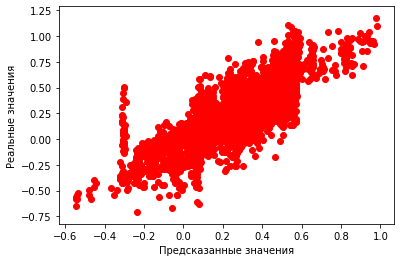

In [ ]:
y_pred_full = best_model.predict(X_test_preproc_full)
print("MSE случайного леса:", metrics.mean_squared_error(y_test_full, y_pred_full))

plt.scatter(y_pred_full, y_test_full, color = 'red')
plt.xlabel('Предсказанные значения')
plt.ylabel("Реальные значения")

С использоанием случайного леса разница в качестве предсказания цены для небольших объемов и всего датасета стала меньше. 

Рассмотрим важность признаков в случайном лесе:

1. 4046 0.348766 
2. 4225 0.195671 
3. 4770 0.118289 
4. small_bags 0.086940 
5. large_bags 0.051831 
6. xlarge_bags 0.045902 
7. conventional 0.034631 
8. organic 0.027002 
9. Albany 0.012053 
10. Atlanta 0.010361 


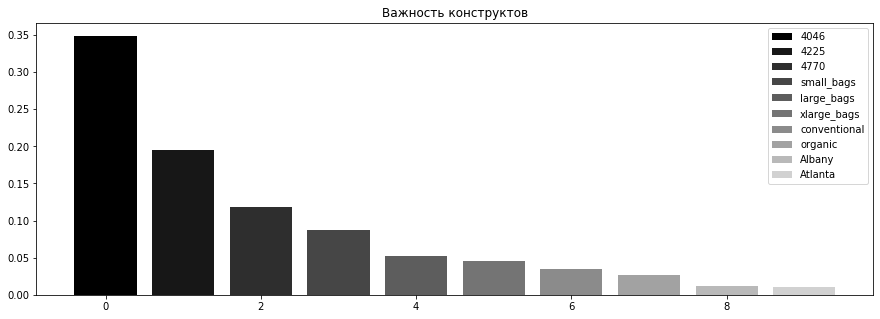

In [ ]:
importances = best_model.feature_importances_
features = X_preproc.columns
indices = np.argsort(importances)[::-1]

# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features[f], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
plt.legend(bars, [u''.join(features[f]) 
                  for f in range(num_to_plot)])

Видно, что наибольшее значение имеет вид авокадо: 4046, 4225 и 4770. Проверим графически:

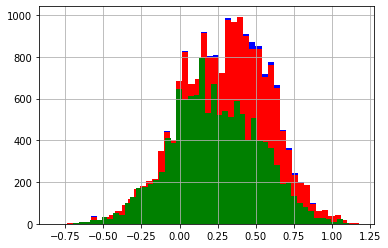

In [ ]:
df_small[df_small['4225'] != 0]['avg_price'].hist(bins=50, color='b')
df_small[df_small['4046'] != 0]['avg_price'].hist(bins=50, color='r')
df_small[df_small['4770'] != 0]['avg_price'].hist(bins=50, color='g')

Заметно, что распределения для разных видов авокадо отличаются, для 4770 гистограммы ниже, чем для других двух. Это может объясняться либо разной ценой на разные виды, либо неравным соотношением их в таблице. 

Можно попробовать предсказывать цену для каждого вида поотдельности, но тогда признаки small_bags, large_bags, xlarge_bags так же придется отбросить, так как их невозможно разделить по видам авокадо. 

## Другой подход

In [ ]:
avo_4046 = data[data['4046'] != 0].drop(columns=['4225', '4770', 'small_bags', 'large_bags', 'xlarge_bags'])
avo_4225 = data[data['4225'] != 0].drop(columns=['4046', '4770', 'small_bags', 'large_bags', 'xlarge_bags'])
avo_4770 = data[data['4770'] != 0].drop(columns=['4046', '4225', 'small_bags', 'large_bags', 'xlarge_bags'])

In [ ]:
def preproc_2(train, test):
    num_cols = train.columns[0]
    cat_cols = ['type', 'region', 'year']

    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(train[cat_cols])
    X_encoded = ohe.transform(train[cat_cols])

    features_names_prefixed = []
    for cats in ohe.categories_:
        for cat in cats:
            features_names_prefixed.append(str(cat))

    X_preproc = pd.concat([train[num_cols], pd.DataFrame(X_encoded, columns=features_names_prefixed, 
                           index=train.index)], axis=1)
    
    X_test_encoded = ohe.transform(test[cat_cols])
    X_test_preproc = pd.concat([test[num_cols], pd.DataFrame(X_test_encoded, columns=features_names_prefixed, 
                           index=test.index)], axis=1)
    return X_preproc, X_test_preproc

num: 4046
4046:
MSE линейной регрессии: 0.03440470371891766


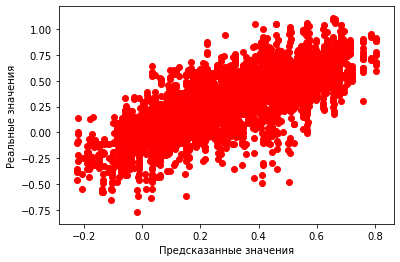

In [ ]:
X_4046 = avo_4046.drop(columns=['avg_price'])
y_4046 = avo_4046['avg_price']
X_4225 = avo_4225.drop(columns=['avg_price'])
y_4225 = avo_4225['avg_price']
X_4770 = avo_4770.drop(columns=['avg_price'])
y_4770 = avo_4770['avg_price']

X_train_4046, X_test_4046, y_train_4046, y_test_4046 = model_selection.train_test_split(X_4046, y_4046, test_size=0.25, random_state=42)
X_preproc_4046, X_test_preproc_4046 = preproc_2(X_train_4046, X_test_4046)

print("4046:")
lin_reg(X_preproc_4046, y_train_4046, X_test_preproc_4046, y_test_4046)

num: 4225
4225:
MSE линейной регрессии: 0.035913207084852586


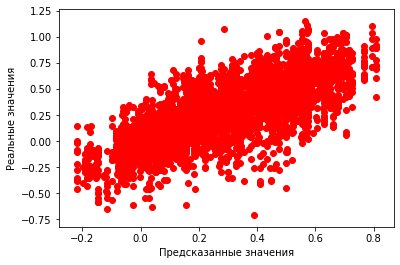

In [ ]:
X_train_4225, X_test_4225, y_train_4225, y_test_4225 = model_selection.train_test_split(X_4225, y_4225, test_size=0.25, random_state=42)
X_preproc_4225, X_test_preproc_4225 = preproc_2(X_train_4225, X_test_4225)

print("4225:")
lin_reg(X_preproc_4225, y_train_4225, X_test_preproc_4225, y_test_4225)

4770:
MSE линейной регрессии: 0.028682018948150957


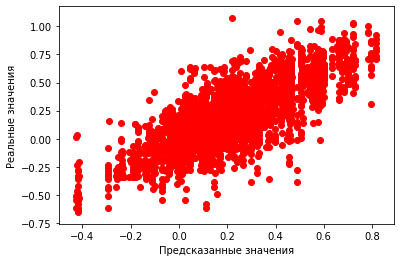

In [ ]:
X_train_4770, X_test_4770, y_train_4770, y_test_4770 = model_selection.train_test_split(X_4770, y_4770, test_size=0.25, random_state=42)
X_preproc_4770, X_test_preproc_4770 = preproc_2(X_train_4770, X_test_4770)

print("4770:")
lin_reg(X_preproc_4770, y_train_4770, X_test_preproc_4770, y_test_4770)

Видно, что качество не ухудшилось заметно для 4046 и 4225, но улучшилось для 4770 даже на таком маленьком признаковом пространстве. Попробуем случайный лес:

In [ ]:
%%time
grid_cv.fit(X_preproc_4046, y_train_4046)

CPU times: user 8min 57s, sys: 919 ms, total: 8min 57s
Wall time: 8min 58s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False], 

Параметры лучшей модели:  {'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
MSE случайного леса: 0.03435905886178695


Text(0, 0.5, 'Реальные значения')

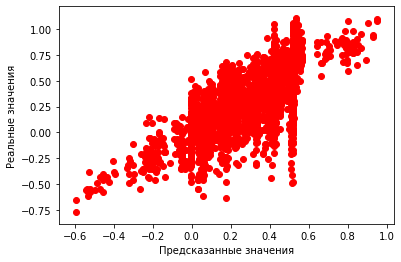

In [ ]:
print("Параметры лучшей модели: ", grid_cv.best_params_)

best_model = grid_cv.best_estimator_
y_pred_4046 = best_model.predict(X_test_preproc_4046)

print("MSE случайного леса:", metrics.mean_squared_error(y_test_4046, y_pred_4046))

plt.scatter(y_pred_4046, y_test_4046, color = 'red')
plt.xlabel('Предсказанные значения')
plt.ylabel("Реальные значения")

In [ ]:
%%time
grid_cv.fit(X_preproc_4225, y_train_4225)

CPU times: user 9min 9s, sys: 1.01 s, total: 9min 10s
Wall time: 9min 10s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False], 

Параметры лучшей модели:  {'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
MSE случайного леса: 0.04047075557926124


Text(0, 0.5, 'Реальные значения')

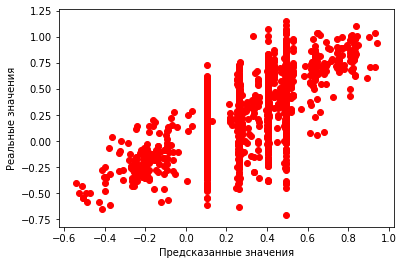

In [ ]:
print("Параметры лучшей модели: ", grid_cv.best_params_)

best_model = grid_cv.best_estimator_
y_pred_4225 = best_model.predict(X_test_preproc_4225)

print("MSE случайного леса:", metrics.mean_squared_error(y_test_4225, y_pred_4225))

plt.scatter(y_pred_4225, y_test_4225, color = 'red')
plt.xlabel('Предсказанные значения')
plt.ylabel("Реальные значения")

In [ ]:
%%time
grid_cv.fit(X_preproc_4770, y_train_4770)

CPU times: user 6min 20s, sys: 813 ms, total: 6min 20s
Wall time: 6min 21s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False], 

Параметры лучшей модели:  {'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
MSE случайного леса: 0.033173426282573776


Text(0, 0.5, 'Реальные значения')

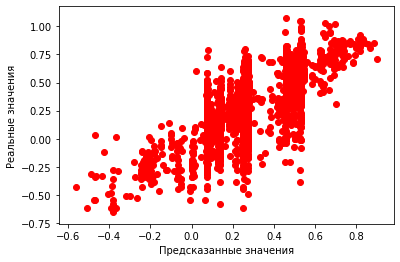

In [ ]:
print("Параметры лучшей модели: ", grid_cv.best_params_)

best_model = grid_cv.best_estimator_
y_pred_4770 = best_model.predict(X_test_preproc_4770)

print("MSE случайного леса:", metrics.mean_squared_error(y_test_4770, y_pred_4770))

plt.scatter(y_pred_4770, y_test_4770, color = 'red')
plt.xlabel('Предсказанные значения')
plt.ylabel("Реальные значения")

Качество редсказаний случайного леса значительно снижается, если предсказывать цену для каждого вида авокадо отдельно в ущерб размеру признакового пространства. Это была плохая идея.


## Градиентный бустинг

Подберём оптимальные параметры  бустинга с помощью hyperopt и обучим его.

In [ ]:
def hyperopt_xgb_score(params):
    xgb = XGBRegressor(**params)
    current_score = cross_val_score(xgb, X_preproc, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    print(current_score, params)
    return -current_score

In [ ]:
xgb_params = {'learning_rate' : hp.choice('learning_rate', np.arange(0.0, 0.5, 0.05)),
              'gamma' : hp.choice('gamma', np.arange(0.5, 1, 0.05)),
              'max_depth': hp.choice('max_depth', np.arange(1, 7, dtype=int)),
}

best = fmin(fn=hyperopt_xgb_score, space=xgb_params, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

[11:14:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-0.031142354379163916
{'gamma': 0.9000000000000004, 'learning_rate': 0.05, 'max_depth': 3}
[11:14:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-0.027677194235830687
{'gamma': 0.6000000000000001, 'learning_rate': 0.4, 'max_depth': 3}
[11:14:38] WARNING: /workspace/src/objective/regression_o

In [ ]:
warnings.filterwarnings('ignore')
best_xgb = XGBRegressor(gamma=0.75, learning_rate=0.5, max_depth=3, n_estimators=1000, random_state=42)
best_xgb.fit(X_preproc, y_train, eval_set=[(X_preproc, y_train), (X_test_preproc, y_test)], eval_metric='rmse', verbose=False)    
results = best_xgb.evals_result()

print("Лучшее качество на обучении:", results['validation_0']['rmse'][-1])
print("Лучшее качество на тесте:", results['validation_1']['rmse'][-1])

[11:18:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Лучшее качество на обучении: 0.15935
Лучшее качество на тесте: 0.161668


Градиентный бустинг не дает особого прироста в качестве, последовательно улучшая результат каждого дерева в ансамбле. Если сравнивать со случайным лесом, то качество $0.16^2 \approx 0.025$, так что по метрикам оба метода показывают одинаковый результат.

## Анализ временных рядов

Мы посмотрели, что умеют делать линейные модели и ансамбли на таком наборе данных, однако не стоит забывать, что предсказание цены - задача, сильно привязанная ко времени. Поэтому намного эффективнее должен быть подход, в котором мы не выкидаваем имеющиеся datetime значения, а опираемся на них в первую очередь.

In [ ]:
data = pd.read_csv(io.StringIO(uploaded['avocado.csv'].decode('utf-8')), index_col='Unnamed: 0', parse_dates=['Date'])
data.columns = ['date', 'avg_price', 'total_vol', '4046', '4225', '4770', 'total_bags', 'small_bags', 'large_bags',
               'xlarge_bags', 'type', 'year', 'region']
data = data.set_index('date')
data = data.sort_index()
data.index.value_counts()

2015-05-24    108
2015-09-13    108
2016-08-07    108
2015-03-08    108
2017-07-02    108
             ... 
2015-03-22    108
2017-07-16    108
2017-06-25    107
2015-12-06    107
2017-06-18    107
Name: date, Length: 169, dtype: int64

Text(0.5, 1.0, 'Динамика средней цены авокадо')

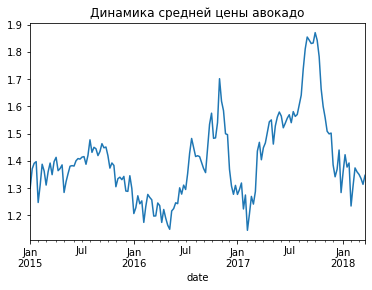

In [ ]:
data_weekly = data.resample('W').mean()
data_weekly.avg_price.plot()
plt.title("Динамика средней цены авокадо")

У нас есть два типа авокадо, посмотрим на динамики их цен отдельно. 

Text(0.5, 1.0, 'Динамика цены на разные авокадо')

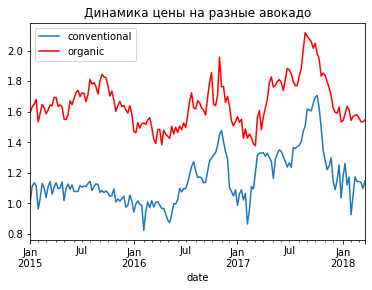

In [ ]:
conventional = data[data['type'] == 'conventional']
organic = data[data['type'] == 'organic']
conventional = conventional.resample('W').mean()
organic = organic.resample('W').mean()

conventional.avg_price.plot()
organic.avg_price.plot(color='r')
plt.legend(['conventional', 'organic'])
plt.title("Динамика цены на разные авокадо")

Посмотрим, на объем продаж обоих типов авокадо и проанализируем временные зависимости.

Text(0.5, 1.0, 'Динамика объема продаж разных авокадо')

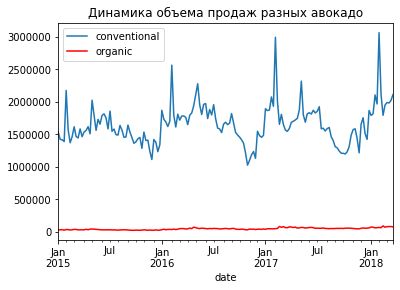

In [ ]:
conventional.total_vol.plot()
organic.total_vol.plot(color='r')
plt.legend(['conventional', 'organic'])
plt.title("Динамика объема продаж разных авокадо")

По построенным графикам зависимостей можно сделать следующие наблюдения относительно обыкновенных (неорганических) авокадо: пиковые зоны для цены совпадают с противоположными пиковыми зонами объема продаж (см. как проседает цена в январе-июле 2016 и затем возрастает до января 2017). Логичным объяснением этого может быть то, что при избытке продаваемых авокадо цена на них падает, а при их дефиците растет. Большое падение цены в январе-феврале 2017 соответсвует резкому пику возрастания кол-ва продаж в тот же период. 

Относительно органических авокадо делать аналогичные выводы нельзя, так как объем продаж слишком мал и зависимостей почти нет.

Разложим ряд целевой переменной на компоненты с помощью STL-декомпозиции. Получим тренд, сезонность и остатки.

Критерий Дики-Фуллера: p=0.245916


<Figure size 1080x720 with 0 Axes>

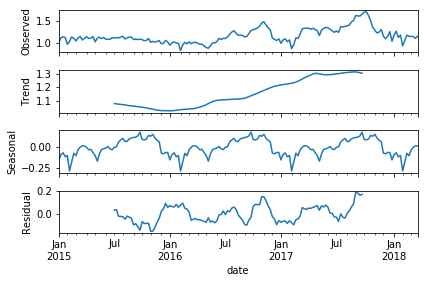

In [ ]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(conventional.avg_price).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(conventional.avg_price)[1])

Ряд очевидно нестационарный: присутсвует явный тренд, сезонность, остатки не похожи на белый шум. Критерий Дики-Фулера не отвергает гипотезу нестационарности. Стабилизируем дисперсию преобразованием Бокса-Кокса и сезонным дифференцированием.

Оптимальный параметр преобразования Бокса-Кокса: -1.537893
Критерий Дики-Фуллера: p=0.161856


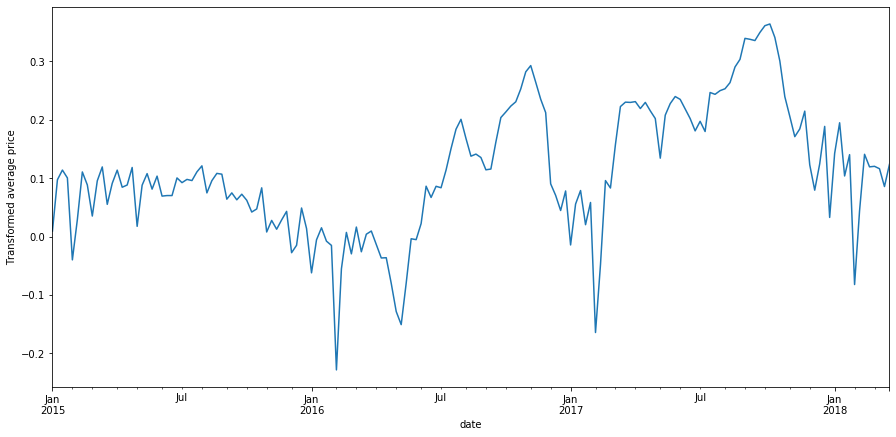

<Figure size 1080x720 with 0 Axes>

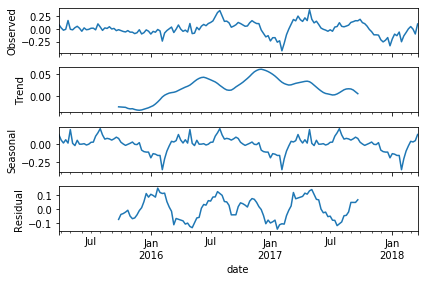

In [ ]:
conventional['avg_price_box'], lmbda = stats.boxcox(conventional.avg_price)
plt.figure(figsize=(10,5))
conventional.avg_price_box.plot()
plt.ylabel(u'Transformed average price')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

conventional['avg_price_box_diff'] = conventional.avg_price_box - conventional.avg_price_box.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(conventional.avg_price_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(conventional.avg_price_box_diff[12:])[1])

Гипотеза нестационарности все еще не отвергается, и на графиках виден тренд и ненормальные остатки. Продифференцируем еще раз.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

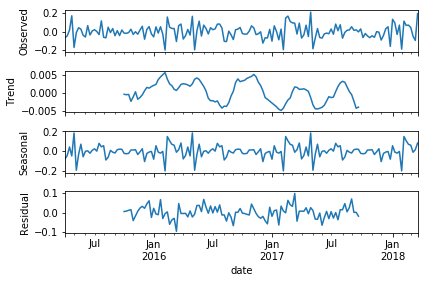

In [ ]:
conventional['avg_price_box_diff2'] = conventional.avg_price_box_diff - conventional.avg_price_box_diff.shift(1)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(conventional.avg_price_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(conventional.avg_price_box_diff2[13:])[1])

Теперь все намного лучше. Посомтрим автоскорреляцию ряда с помощью построения коррелограмм и выявим ключивые лаги.

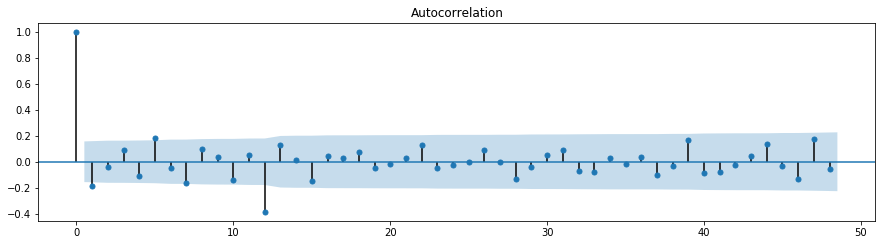

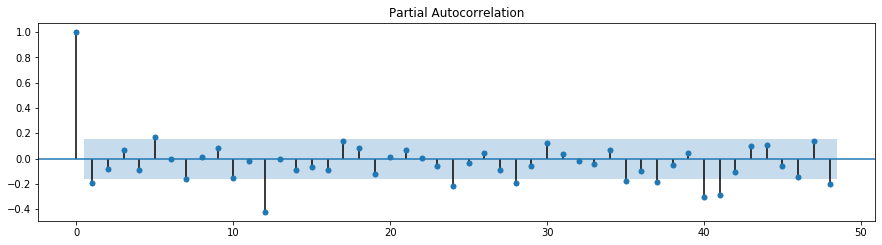

In [ ]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(conventional.avg_price_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(conventional.avg_price_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Максимальный сезонный лаг - 12. Максимальный несезонный также 12. Для начального приближения возьмем параметры Начальные приближения: Q=1, q=2, P=1, p=1.

In [ ]:
# Делаем перебор всех значений
ps = range(0, 2)
d = 1
qs = range(0, 3)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

In [ ]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [ ]:
%%time
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        # стандарт.ф-ия сезонной модели АРИМА
        model=sm.tsa.statespace.SARIMAX(conventional.avg_price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 32.8 s, sys: 24.3 s, total: 57.2 s
Wall time: 28.8 s


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

# можем по критерию оценить, как сильно уменьшение числа параметров сказывается на качестве

      parameters         aic
21  (1, 2, 0, 1) -431.968650
23  (1, 2, 1, 1) -430.074146
5   (0, 1, 0, 1) -427.714267
9   (0, 2, 0, 1) -426.460119
17  (1, 1, 0, 1) -426.217564


In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      avg_price_box   No. Observations:                  169
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 12)   Log Likelihood                 220.984
Date:                            Thu, 19 Dec 2019   AIC                           -431.969
Time:                                    13:41:22   BIC                           -416.719
Sample:                                01-04-2015   HQIC                          -425.775
                                     - 03-25-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7379      0.093     -7.977      0.000      -0.919      -0.557
ma.L1          0.5355      0.104   

По представленным данным о настренной модели с лучшим (наим.) значением критерия Акаике (AIC) видим, что остатки модели автокоррелированы. 

Проведем более подробный аналих остатков:

Критерий Стьюдента: p=0.731545
Критерий Дики-Фуллера: p=0.000000


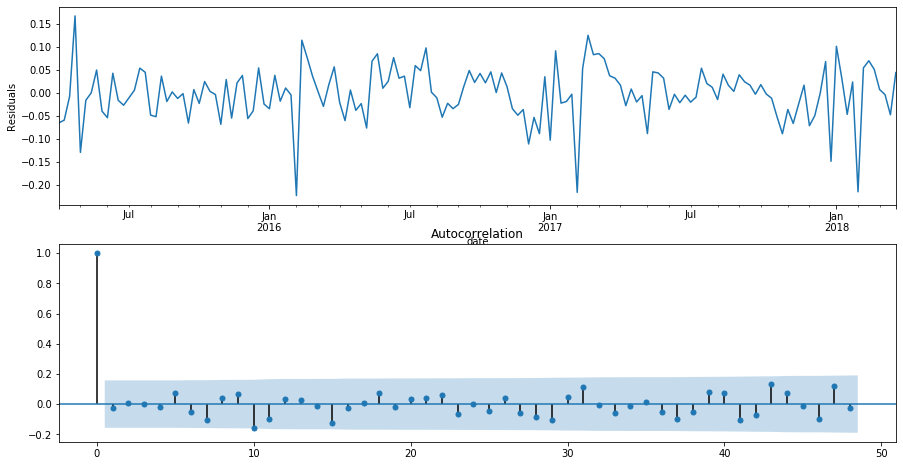

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (судя по коррелограмме: лаги не сезонные). 

Посмотрим, насколько хорошо модель описывает данные:

In [ ]:
# необходима функция, осуществляющая обратное преобразование Бокса-Кокса (ее нет в стандартной реализации python)
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Text(0.5, 1.0, 'Conventional avocado prices')

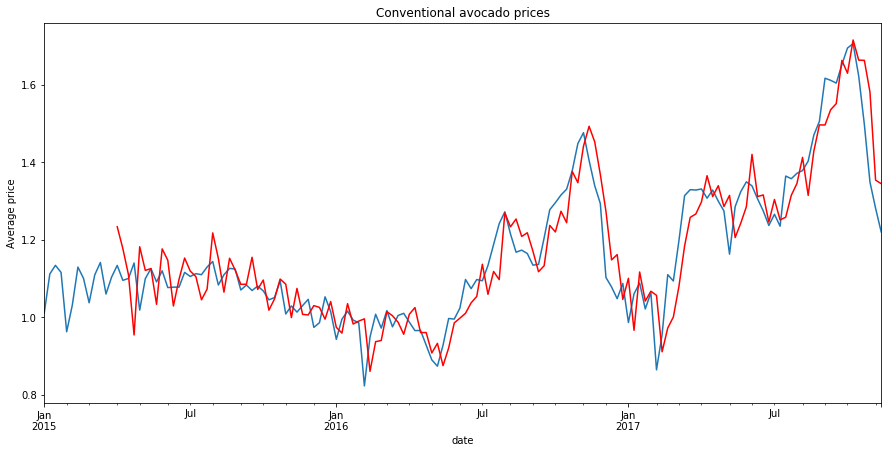

In [ ]:
conventional['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
conventional.avg_price[:150].plot()
conventional.model[13:150].plot(color='r')
plt.ylabel('Average price')
plt.title("Conventional avocado prices")

Предсказание вышло неплохим, несмотря на небольшое смещение по времени.

## Финальный прогноз



Text(0.5, 1.0, 'Avocado prices predictions')

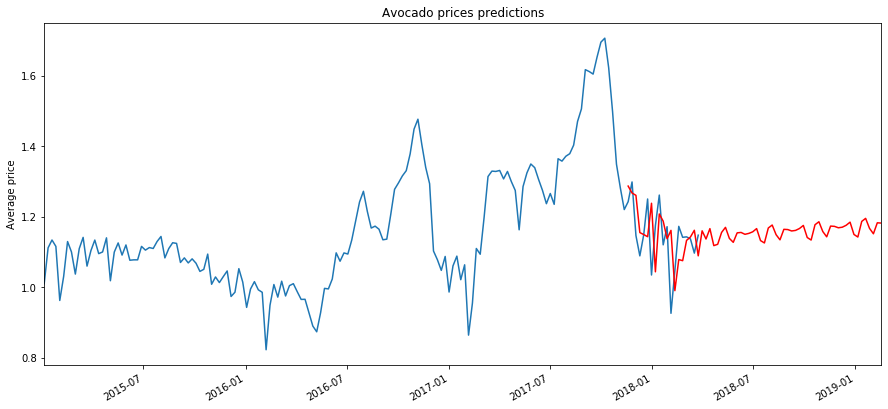

In [ ]:
conventional2 = conventional[['avg_price']]
date_list = [datetime.datetime.strptime("2018-03-25", "%Y-%m-%d") + relativedelta(weeks=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns=conventional2.columns)
conventional2 = pd.concat([conventional2, future])

# помним про обратное преобраование Бокса-Кокса, т.к.построенная модель ничего не знает об изначальном ряде.
conventional2['forecast'] = invboxcox(best_model.predict(start=150, end=300), lmbda)
conventional2.tail()

plt.figure(figsize=(15,7))
conventional2.avg_price.plot()
conventional2.forecast.plot(color='r')
plt.ylabel('Average price')
plt.title('Avocado prices predictions')

Видно, что предсказание по временному ряду улавливает далеко не все изменения в цене: не передает сложный тренд и сезонность. Дальнейшим улучшением прогноза может служить использование других более сложных и чутких к имеющимся данным моделей.

## Выводы

Анализ данных и построение моделей машинного обучения на имеющемся датасете позволяют сделать следующие заключения:


1.   Выявлен рост средней цены авокадо от года к году.
2.   Наблюдается сезонное увеличение средней цены во второй половине года.
3.   Существует большая разница между средними ценами на органические и обычные авокадо.
4.   Из-за особенностей сбора данных не получилось выявить разницу в средней цене для разнх видов (PLU) авокадо, однако случайный лес подчеркнул важность данных признаков.
5.   Средняя цена на авокадо слабо зависит от региона.
6.   Средняя цена тем меньше, чем больше объем продаж авокадо и наборот (вывод подкрепляется графиком и знаком ипри коэф-тах регрессии 4046 и 4770).
7.   Малый и большой объем продаж имеют разные распределения и имеет смысл прогноизровать цену для этих случаев отдельно.
8.   Лучше всего в предсказании себя показал случайный лес на 50 деревьях для всех авокадо с небольшим объемом продаж (MSE = 0.0255). Градиентный бустинг не улучшил это качество.
9.   При анализе временного ряда средней цены выявлен растущий тренд и годовая сезонность для авокадо обычного типа.
10.   Предсказание на основе модели SARIMA оказалось недостаточно чувствительным для построения достоверного прогноза.